<a href="https://colab.research.google.com/github/SrivenkateswaraRao/Research-Project/blob/master/Pest_Classifier_Mask_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyDrive


In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import cv2

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [ ]:
file_list = drive.ListFile(
    {'q': "'1aXb25Wp9sG7mL6AQgYY9ElrGcERi95JU' in parents"}).GetList()

for f in file_list:
    print('title: %s, id: %s' % (f['title'], f['id']))
    fname = f['title']
    print('downloading to {}'.format(fname))
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(fname)

title: LABELS_V3.0.zip, id: 1czHz_vAOwNIhOMILhNBfocUJAVHwzwPZ
downloading to LABELS_V3.0.zip
title: GREENPATROL_DB_V2.0.zip, id: 1b7KAiGabJtZ_EynnwPJ36PfpZUEvrMvV
downloading to GREENPATROL_DB_V2.0.zip
title: GREENPATROL_DB_V3.0.zip, id: 1it-Tl5LJCND0A-eSWMsTehRU9LWxNvLd
downloading to GREENPATROL_DB_V3.0.zip
title: LABELS_V2.0.zip, id: 1urJgtKjKnczmarU3RKYrxXtQTbUAOUin
downloading to LABELS_V2.0.zip
title: LABELS_V2.0.zip, id: 1aUpDrV9Rsu8ZOKVR64LXPfitJ26CQR-K
downloading to LABELS_V2.0.zip
title: LABELS.zip, id: 1Rr_6cmS07z_hDZ1FVX6GBhUgLWC7cMS0
downloading to LABELS.zip
title: GREENPATROL_DB_V1.0.zip, id: 1LrZaY2eXwTII9KqoTj2ZF4cvOkJI9q7V
downloading to GREENPATROL_DB_V1.0.zip
title: LABELS_V1.0.zip, id: 1x097xXtubVGiPXv1OAHieXVpd16DwUr2
downloading to LABELS_V1.0.zip
title: predefined_classes.txt, id: 1srJJMul6750VCSL2-z9KrJ_QN9i6WK5Y
downloading to predefined_classes.txt
title: mask_rcnn_coco.h5, id: 1fskTG05x1LKNQyD_6AZnQPi1jRCvkFl5
downloading to mask_rcnn_coco.h5


Downloading annotations 

In [ ]:
#download_Annotations.GetContentFile('LABELS_V1.0.zip')

!unzip LABELS_V3.0.zip -d '/content/Tomato/Labels'

In [ ]:
#download_Pests.GetContentFile('GREENPATROL_DB_V1.0.zip')
!unzip GREENPATROL_DB_V3.0.zip -d '/content/Tomato/Images'

In [ ]:
import tensorflow.keras

from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

# New Section

Loading Data Set 

In [ ]:
!pip install mrcnn


In [ ]:
pip install scikit-image


In [ ]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from matplotlib import pyplot
from skimage.io import imread
from skimage.transform import resize

Defining a class for Data Set 

In [ ]:
# train set
train_set = PestDataset()
train_set.load_dataset('content/Tomato', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))



Train: 2000


In [ ]:
type(train_set[0])

In [ ]:
# test/val set
test_set = PestDataset()
test_set.load_dataset('content/Tomato', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Test: 2000


(1544, 2064, 3)
(1544, 2064, 12)


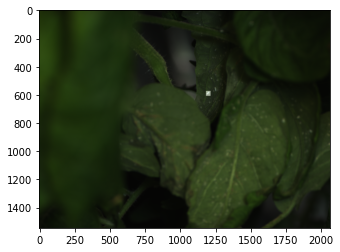

In [ ]:
# load an image
image_id = 4
image = train_set.load_image(image_id)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)
# plot image
pyplot.imshow(image)
# plot mask
pyplot.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
pyplot.show()

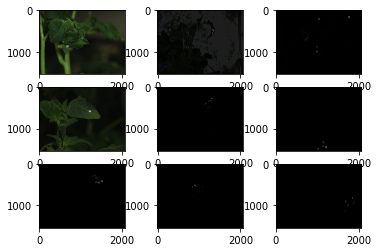

In [ ]:
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	image = train_set.load_image(i)
	pyplot.imshow(image)
	# plot all masks
	mask, _ = train_set.load_mask(i)
	for j in range(mask.shape[2]):
		pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
# show the figure
pyplot.show()

In [ ]:
def resize_image(image_path,IMAGE_SIZE):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

In [ ]:

# example of inference with a pre-trained coco model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from mrcnn.visualize import display_instances
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset

class PestDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        self.add_class("object", 1, "egg_wf")
        self.add_class("object", 2, "egg_bt")
        self.add_class("object", 3, "egg_ta")
        self.add_class("object", 4, "wf")
        self.add_class("object", 5, "bt")
        self.add_class("object", 6, "ta")
        self.add_class("object", 7, "ta_maps")
        self.add_class("object", 8, "ta_larvae")
        self.add_class("object", 9, "ta_maps+larvae")
        self.add_class("object", 10, "tomato")
        images_dir = '/'+ dataset_dir + '/Images/GREENPATROL_DB_V1.0/'
        annotations_dir = '/' + dataset_dir + '/Labels/LABELS/'
        # find all images
        for filename in listdir(images_dir):
            # extract image id
            image_id = filename[:-4]
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        names = list()
        for box in root.findall('.//object'):
            xmin = int(box.find('.//bndbox/xmin').text)
            xmax = int(box.find('.//bndbox/xmax').text)
            ymin = int(box.find('.//bndbox/ymin').text)
            ymax = int(box.find('.//bndbox/ymax').text)
            name = box.find('.//name').text
            coors = [xmin, ymin, xmax, ymax]
            names.append(name)
            boxes.append(coors)
            width = int(root.find('.//size/width').text)
            height = int(root.find('.//size/height').text)
        return boxes, width, height, names 

    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h, n  = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index(n[i]))
        return masks, asarray(class_ids, dtype='int32')

    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']
        
   
    

In [ ]:
# enumerate all images in the dataset
for image_id in train_set.image_ids:
	# load image info
	info = train_set.image_info[image_id]
	# display on the console
	print(info)

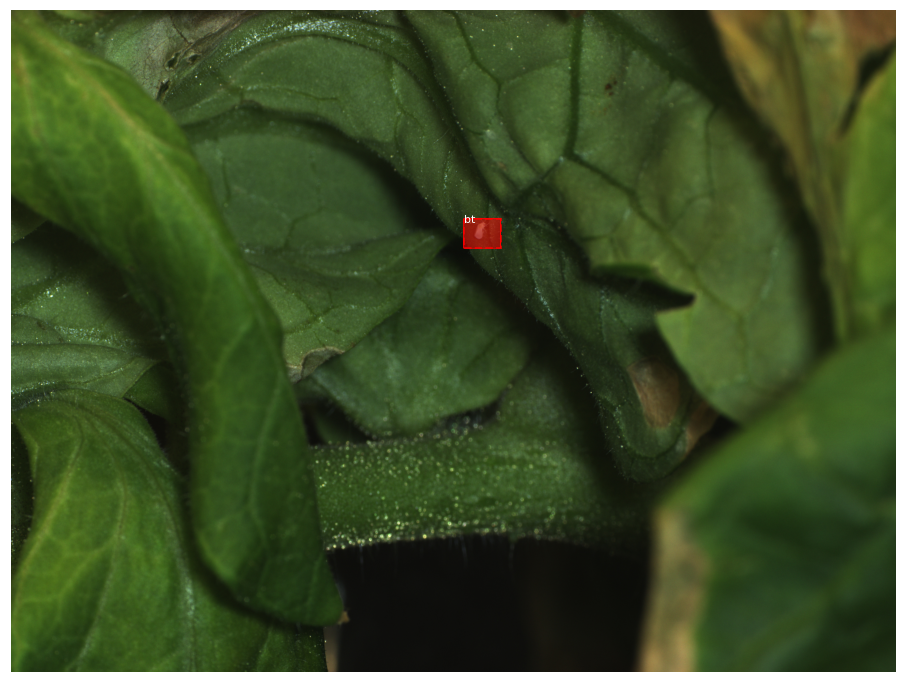

In [ ]:
# define image id
image_id = 678
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

list

In [ ]:
# define a configuration for the model
class PestsConfig(Config):
	# Give the configuration a recognizable name
	NAME = "Pests_cfg"
	# Number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 9
	# Number of training steps per epoch
	STEPS_PER_EPOCH = 5

# prepare config
config = PestsConfig()
config.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                22
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

In [ ]:
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')

In [ ]:
import tensorflow
print(tensorflow.__version__)

2.2.0


In [ ]:
import keras
print(keras.__version__)

2.3.1


In [ ]:
!pip uninstall tensorflow -y


Uninstalling tensorflow-2.2.0:
  Successfully uninstalled tensorflow-2.2.0


In [ ]:
pip install tensorflow==1.15.0


In [ ]:
!pip uninstall keras -y


Uninstalling Keras-2.3.1:
  Successfully uninstalled Keras-2.3.1


In [ ]:
pip install keras==2.2.4